# El evaluador de precios de productos (continuación)

Un modelo que puede estimar cuánto cuesta algo a partir de su descripción.

## ¡POR FIN, llegó el momento de realizar los ajustes precisos!

Después de toda esta preparación de datos y del aprendizaje automático tradicional, finalmente llegamos al momento que estaba esperando: el ajuste preciso de un modelo.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# movimos nuestro Tester a un paquete separado
# lo llamamos mediante Tester.test(function_name, test_dataset)

from testing import Tester

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in en HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [7]:
# ¡Evitemos tener que volver a curar todos nuestros datos! Carguemos los archivos pickle:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
# OpenAI recomienda realizar ajustes con poblaciones de 50 a 100 ejemplos
# Pero como nuestros ejemplos son muy pequeños, sugiero que utilicemos 200 ejemplos (y 1 época)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Paso 1

Preparar nuestros datos para el ajuste fino en formato JSONL (líneas JSON) y subirlos a OpenAI

In [9]:
# Primero, trabajemos en un buen mensaje para un modelo Frontier
# Observe que estoy eliminando el "al dólar más cercano"
# Cuando entrenemos nuestros propios modelos, necesitaremos hacer que el problema sea lo más fácil posible,
# pero un modelo Frontier no necesita tal simplificación.

def messages_for(item):
    system_message = "Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones."
    user_prompt = item.test_prompt().replace(" redondeado al dólar más cercano","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"El Precio es ${item.price:.2f}"}
    ]

In [10]:
messages_for(train[0])

[{'role': 'system',
  'content': 'Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones.'},
 {'role': 'user',
  'content': '¿Cuánto cuesta esto?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'},
 {'role': 'assistant', 'content': 'El Precio es $226.95'}]

In [11]:
# Convierte los elementos en una lista de objetos json: una cadena "jsonl"
# Cada fila representa un mensaje en el formato:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "Estimas los precios de los art\u00edculos. Respondes solo con el precio, sin explicaciones."}, {"role": "user", "content": "\u00bfCu\u00e1nto cuesta esto?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "El Precio es $226.95"}]}
{"messages": [{"role": "system", "content": "

In [13]:
# Convierte los elementos en jsonl y escríbelos en un archivo

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [15]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [16]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-GPAaJXhXMCkRdSDsWFx74H', bytes=194543, created_at=1733931897, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [18]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-9d3RFyqVUGFK2JJRmUkLPN', bytes=48536, created_at=1733931922, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

# Paso 2

Me encanta Weights and Biases, una hermosa plataforma gratuita para monitorear las tareas de entrenamiento.
Weights and Biases está integrado con OpenAI para realizar ajustes.

Primero, crea tu cuenta gratuita de Weights & Biases en:

https://wandb.ai

Desde el menú Avatar >> Configuración, cerca de la parte inferior, puedes crear una clave API.

Luego, visita el panel de control de OpenAI en:

https://platform.openai.com/account/organization

En la sección de integraciones, puedes agregar tu clave de Weights & Biases.

## ¡Y ahora es momento de realizar ajustes!

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [21]:
train_file.id

'file-GPAaJXhXMCkRdSDsWFx74H'

In [22]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-p4rQmPhZZla0Ql7HkR6Tr49P', created_at=1733933434, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pEVhVaVVGq4jT3s3eYJFbeAM', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-GPAaJXhXMCkRdSDsWFx74H', validation_file='file-9d3RFyqVUGFK2JJRmUkLPN', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-p4rQmPhZZla0Ql7HkR6Tr49P'))], user_provided_suffix='pricer')

In [23]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-p4rQmPhZZla0Ql7HkR6Tr49P', created_at=1733933434, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pEVhVaVVGq4jT3s3eYJFbeAM', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-GPAaJXhXMCkRdSDsWFx74H', validation_file='file-9d3RFyqVUGFK2JJRmUkLPN', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-p4rQmPhZZla0Ql7HkR6Tr49P'))], user_provided_suffix='pricer')], object='list', has_more=False)

In [24]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [25]:
job_id

'ftjob-p4rQmPhZZla0Ql7HkR6Tr49P'

In [26]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-p4rQmPhZZla0Ql7HkR6Tr49P', created_at=1733933434, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pEVhVaVVGq4jT3s3eYJFbeAM', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-GPAaJXhXMCkRdSDsWFx74H', validation_file='file-9d3RFyqVUGFK2JJRmUkLPN', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-p4rQmPhZZla0Ql7HkR6Tr49P'))], user_provided_suffix='pricer')

In [31]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-SUZcrMwADLLQQEMUGgozLRI6', created_at=1733934036, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-sNAJrVUA2Q4WS8c7Wde8xdiB', created_at=1733934032, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-WMjZxPqn7C3KjWcZkZhH8VgO', created_at=1733933956, level='info', message='Step 200/200: training loss=1.00, validation loss=1.01, full validation loss=1.00', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 0.9960129857063293, 'valid_loss': 1.0093616909450955, 'total_steps': 200, 'full_valid_loss': 0.9953101560804579, 'train_mean_token_accuracy': 0.7777777910232544, 'valid_mean_token_accuracy': 0.7777777777777778, 'full_valid_mean_token_accuracy': 0.8177777777777778}, type='metrics'),
 FineTuningJobEvent(id='ftevent-RaWX2UFNT2OanMxAlZBiQMJY', created_at

# Step 3

Test our fine tuned model

In [32]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [33]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:frogames-formaci-n:pricer:AdJjsGIf'

In [34]:
# The prompt

def messages_for(item):
    system_message = "Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones."
    user_prompt = item.test_prompt().replace(" redondeado al dólar más cercano","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "El Precio es $"}
    ]

In [35]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones.'},
 {'role': 'user',
  'content': "¿Cuánto cuesta esto?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'El Preci

In [36]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [37]:
get_price("El precio es aproximadamente $99.99 ya que blah blah")

99.99

In [38]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [39]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
393.69


In [40]:
print(test[0].test_prompt())

¿Cuánto cuesta esto redondeado al dólar más cercano?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


1: Guess: $393.69 Truth: $374.41 Error: $19.28 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $143.65 Truth: $225.11 Error: $81.46 SLE: 0.20 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $58.95 Truth: $61.68 Error: $2.73 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $799.95 Truth: $599.99 Error: $199.96 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $39.95 Truth: $16.99 Error: $22.96 SLE: 0.68 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $22.22 Truth: $31.99 Error: $9.77 SLE: 0.12 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $161.18 Truth: $101.79 Error: $59.39 SLE: 0.21 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $199.00 Truth: $289.00 Error: $90.00 SLE: 0.14 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $519.95 Truth: $635.86 Error: $115.91 SLE: 0.04 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $139.99 Truth: $65.99 Error: $74.00 SLE: 0.55 I

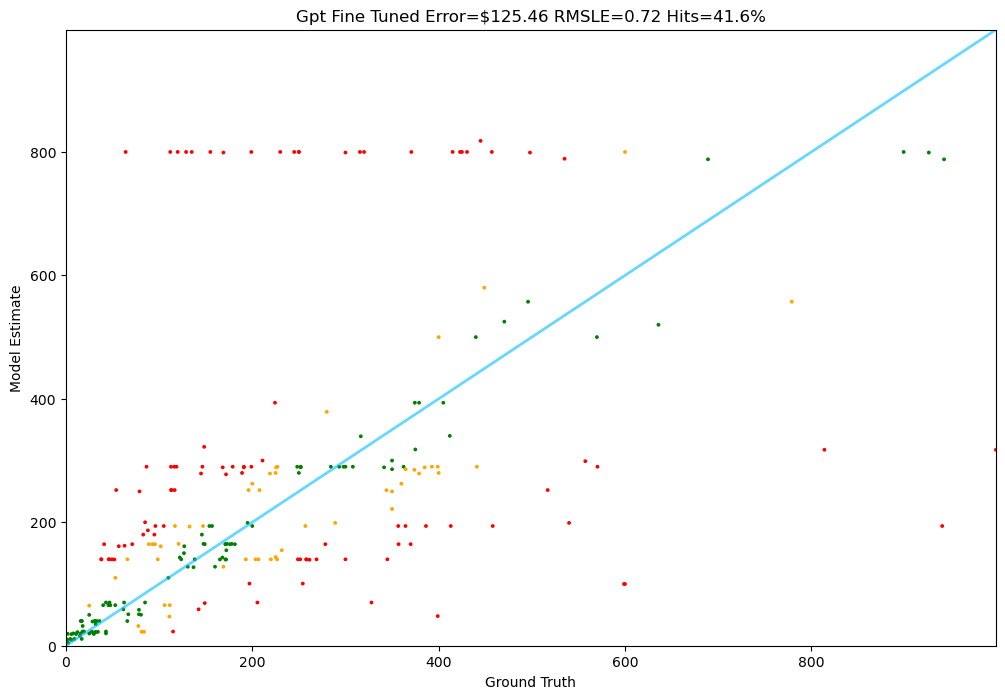

In [41]:
Tester.test(gpt_fine_tuned, test)